In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

%run Data.ipynb
print("Setup Complete")

Setup Complete


# Short overview of progress

## What I'm observing
The notable visual benchmarks in exploratory stage are as follows:
- Percent of generation fulfilled with wind over months
- Moving average of day-ahead price over months
- Percent of generation fulfilled with wind over months along the prices
- Average discrepancy between wind production forecast and actual production
- Intraday prices
- Autocorrelation plots
- Correlations between the time series

This all goes to prove the following hypothesis:
- More wind power drops the baseload day-ahead price, but only up to the point where the producers start to anticipate having to pay up to the grid for not fulfilling their obligation to produce due to a weather risk (can be seen in TS below)
- More wind power causes more imbalance fees to be paid by non-fulfilling generators to the TSO and more to be traded intraday.

## Questions to look into when a bit more done with exploration
- Where exactly is the point where the curve of baseload price starts growing with the growth of wind penetration?
- Can a model be trained to identify that point using current market conditions as features?
- Can we correlate the average success of production forecast for the region with the rate of change of wind baseload price due to day-ahead production stochasticity?
- Can successful experiments be extrapolated onto other markets with similar design?

## Quick notes right away
- DK2 has a lower percent of wind generation and has slightly higher day-ahead prices at the same time.
- When wind power is gradually introduced, the day-ahead prices first grow, then start to decrease, then hit a low point and start to grow again up to some point and decrease again
- Discrepancies between wind production and prognosis seem to be cyclical. High in 2013 when WP was being introduced and on the same level or even decreasing over time
- Somewhere between 2013 and 2014 in Denmark there was a REALLY awkward spike in both intraday and day-ahead prices. What was that?
- Intraday prices in general seem to reflect the patterns of day-ahead prices.
- Judging by average forecast-production discrepancies, winds seem to be more unpredictable in winter (?)

In [2]:
# global data

hours = dk_consumption_forecast['Hours'].unique()
settlement_periods = range(49) # half-hours
pass

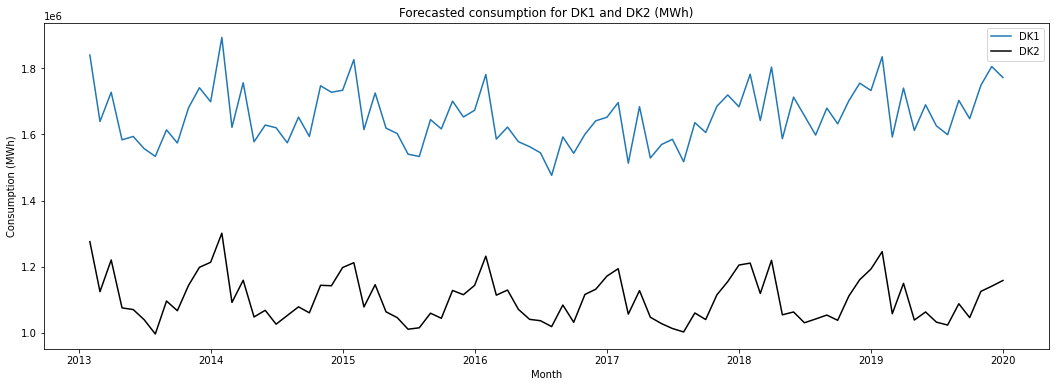

In [3]:
# forecasted consumption, Denmark

# resample for graphs
dk_consumption_forecast_monthly = dk_consumption_forecast_daily.resample('M').sum() # taking monthly sum here for the price
months = dk_consumption_forecast_monthly.index

plt.figure(figsize=(18,6))
plt.title('Forecasted consumption for DK1 and DK2 (MWh)')
plt.plot(months, dk_consumption_forecast_monthly['DK1'], label='DK1')
plt.plot(months, dk_consumption_forecast_monthly['DK2'], label='DK2', color='black')

plt.xlabel('Month')
plt.ylabel('Consumption (MWh)')

plt.legend()
plt.show()
pass # supress printing

No handles with labels found to put in legend.


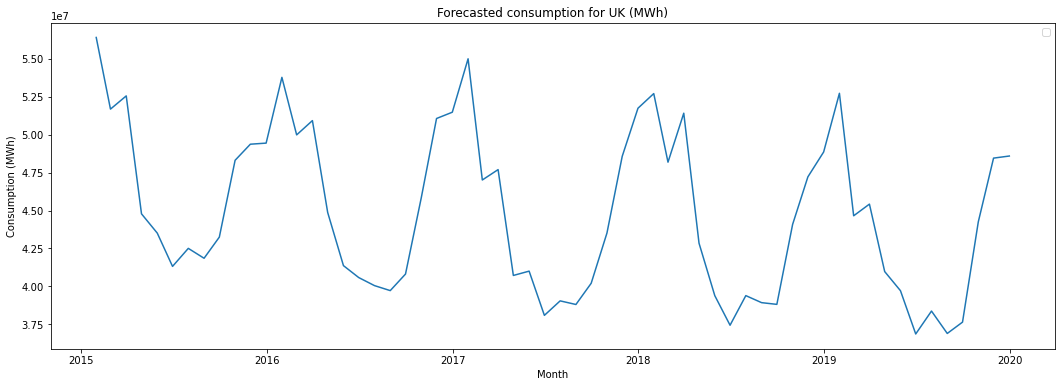

In [4]:
# forecasted consumption, UK - FIX DATA FILE

uk_consumption_forecast_monthly = uk_consumption_forecast.resample('M').sum()
months = uk_consumption_forecast_monthly.index

plt.figure(figsize=(18,6))
plt.title('Forecasted consumption for UK (MWh)')
plt.plot(months, uk_consumption_forecast_monthly['Quantity'])

plt.xlabel('Month')
plt.ylabel('Consumption (MWh)')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

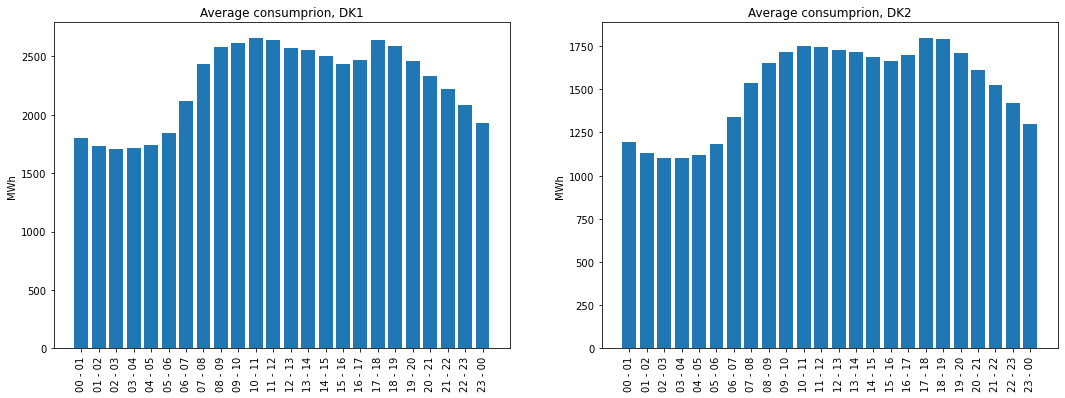

In [5]:
# average forecasted consumption for specfic hours, DK
plt.figure()

averages_dk1 = []
averages_dk2 = []

for hour in hours:
    daily_mean = dk_consumption_forecast.loc[dk_consumption_forecast['Hours'] == hour]
    hourly_mean = daily_mean.mean()
    averages_dk1.append(hourly_mean['DK1'])
    averages_dk2.append(hourly_mean['DK2'])

    
plt.figure(figsize=(18,6))

ax1 = plt.subplot(1, 2, 1)
plt.bar(hours, averages_dk1)
plt.xticks(rotation=90)
ax1.set_title('Average consumprion, DK1')
ax1.set_ylabel('MWh')

ax2 = plt.subplot(1, 2, 2)
plt.bar(hours, averages_dk2)
plt.xticks(rotation=90)
ax2.set_title('Average consumprion, DK2')
ax2.set_ylabel('MWh')


plt.show()

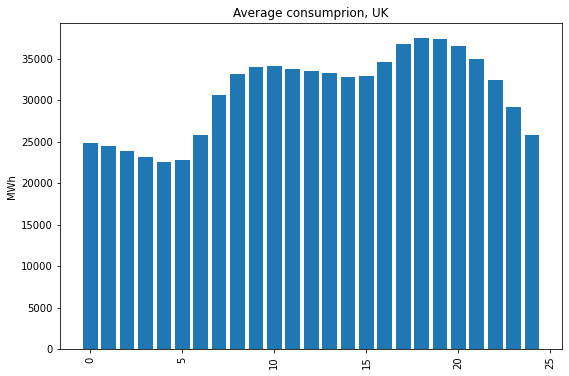

In [6]:
# average forecasted consumption for specfic hours, UK

averages_uk = []

for hour in settlement_periods:
    daily_mean = uk_consumption_forecast.loc[uk_consumption_forecast['SettlementPeriod'] == hour]
    hourly_mean = daily_mean['Quantity'].mean()
    averages_uk.append(hourly_mean)

    
plt.figure(figsize=(9,6))

ax = plt.bar([s//2 for s in settlement_periods], averages_uk)
plt.xticks(rotation=90)
plt.title('Average consumprion, UK')
plt.ylabel('MWh')

plt.show()
pass

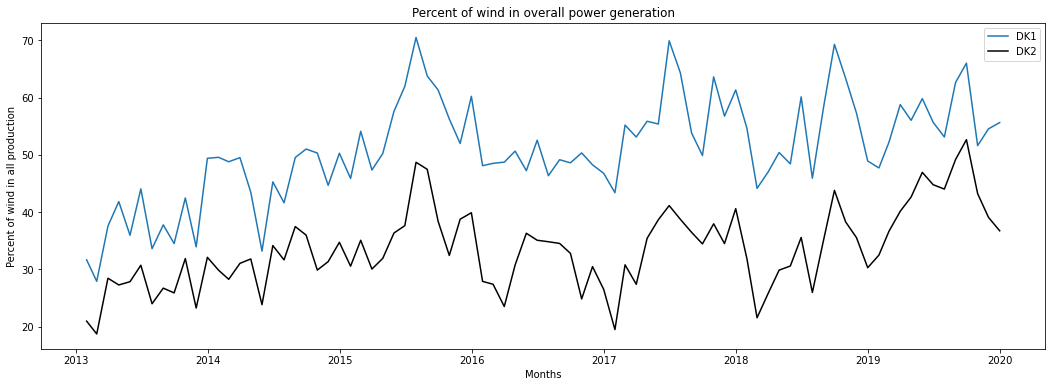

In [7]:
# percent of wind in all production, dk

# prepare chart data
chart_data_dk1 = pd.DataFrame({'Wind': dk_production_wind_daily['DK1'], 'Other': dk_production_all_daily['DK1'] - dk_production_wind_daily['DK1']})
chart_data_dk2 = pd.DataFrame({'Wind': dk_production_wind_daily['DK2'], 'Other': dk_production_all_daily['DK2'] - dk_production_wind_daily['DK2']})
chart_data_dk1.index = dk_production_all_daily.index
chart_data_dk2.index = dk_production_all_daily.index


# resample for graphs
chart_data_dk1 = chart_data_dk1.resample('M').sum()
chart_data_dk2 = chart_data_dk2.resample('M').sum()


plt.figure(figsize=(18,6))

plt.title("Percent of wind in overall power generation")
plt.xlabel('Months')
plt.ylabel('Percent of wind in all production')

sns.lineplot(data=(chart_data_dk1['Wind'] / (chart_data_dk1['Other'] + chart_data_dk1['Wind']) * 100), label="DK1")
sns.lineplot(data=(chart_data_dk2['Wind'] / (chart_data_dk2['Other'] + chart_data_dk2['Wind']) * 100), color='black', label="DK2")
pass

In [8]:
uk_wind_production['Settlement Date'] = pd.to_datetime(uk_wind_production['Settlement Date'])
uk_wind_production.index = uk_wind_production['Settlement Date']
uk_wind_production_monthly = uk_wind_production.resample('M').sum()

In [9]:
uk_production_all['Settlement Date'] = pd.to_datetime(uk_production_all['Settlement Date'])
uk_production_all.index = uk_production_all['Settlement Date']
uk_production_all_monthly = uk_production_all.resample('M').sum()

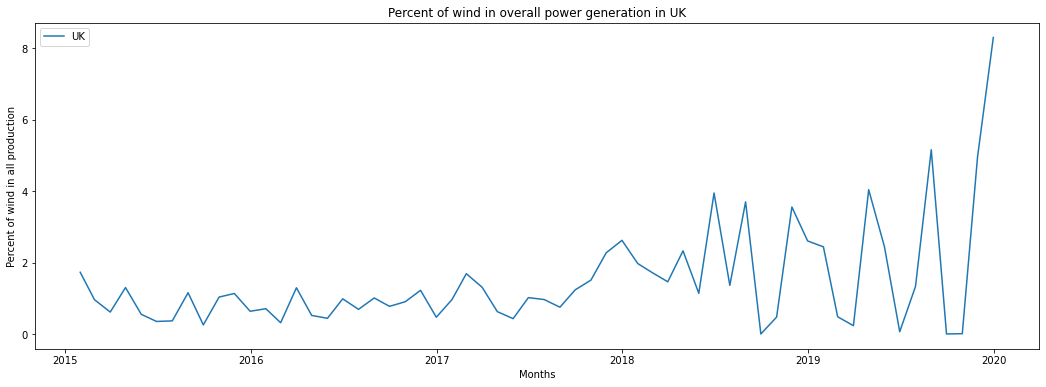

In [10]:
# percent of wind in all production, UK

# prepare chart data
chart_data_uk = pd.DataFrame({'Wind': uk_wind_production_monthly['Quantity '], 'Other': uk_production_all_monthly['Quantity'] - uk_wind_production_monthly['Quantity ']})
chart_data_uk = chart_data_uk.fillna(chart_data_uk.mean())
chart_data_uk.index = uk_production_all_monthly.index


# resample for graphs
chart_data_uk = chart_data_uk.resample('M').sum()


plt.figure(figsize=(18,6))

plt.title("Percent of wind in overall power generation in UK")
plt.xlabel('Months')
plt.ylabel('Percent of wind in all production')

sns.lineplot(data=(chart_data_uk['Wind'] / (chart_data_uk['Other'] + chart_data_uk['Wind']) * 100), label="UK")
pass

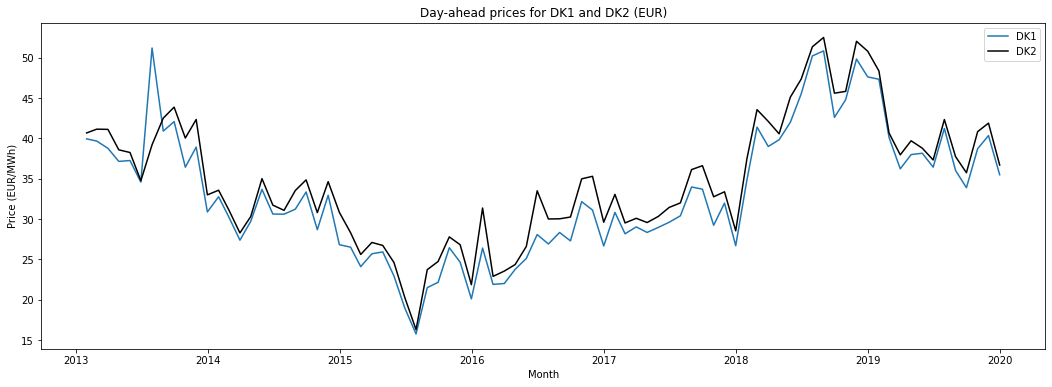

In [11]:
# resample for graphs
dk_DA_prices_monthly = dk_DA_prices_daily.resample('M').mean() # taking monthly mean here for the price
months = dk_DA_prices_monthly.index

plt.figure(figsize=(18,6))
plt.title('Day-ahead prices for DK1 and DK2 (EUR)')
plt.plot(months, dk_DA_prices_monthly['DK1'], label='DK1')
plt.plot(months, dk_DA_prices_monthly['DK2'], label='DK2', color='black')

plt.xlabel('Month')
plt.ylabel('Price (EUR/MWh)')

plt.legend()
plt.show()
pass # supress printing

In [12]:
uk_DA_prices['Date'] = pd.to_datetime(uk_DA_prices['Date'])
uk_DA_prices.index = uk_DA_prices['Date']
uk_DA_prices_monthly = uk_DA_prices.resample('M').mean()

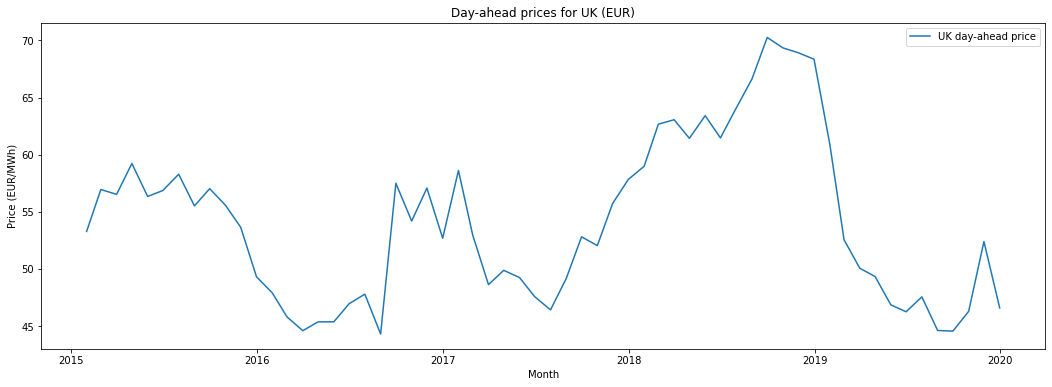

In [13]:
months = uk_DA_prices_monthly.index

plt.figure(figsize=(18,6))
plt.title('Day-ahead prices for UK (EUR)')
plt.plot(months, uk_DA_prices_monthly['Price'], label='UK day-ahead price')

plt.xlabel('Month')
plt.ylabel('Price (EUR/MWh)')

plt.legend()
plt.show()
pass # supress printing

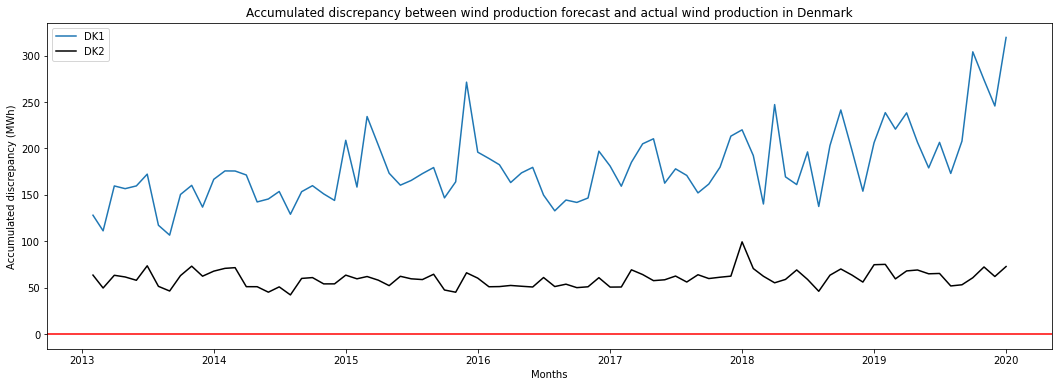

In [14]:
discrepancies_dk = pd.DataFrame({'DK1': abs(dk_wind_production['DK1'] - dk_wind_forecast['DK1']), 'DK2': abs(dk_wind_production['DK2'] - dk_wind_forecast['DK2'])})
discrepancies_dk_monthly = discrepancies_dk.resample('M').mean()

plt.figure(figsize=(18,6))

plt.plot(discrepancies_dk_monthly.index, discrepancies_dk_monthly['DK1'], label='DK1')
plt.plot(discrepancies_dk_monthly.index, discrepancies_dk_monthly['DK2'], label='DK2', color='black')
plt.axhline(0, color='red')

plt.title('Accumulated discrepancy between wind production forecast and actual wind production in Denmark')
plt.xlabel('Months')
plt.ylabel('Accumulated discrepancy (MWh)')
plt.legend()

pass

In [15]:
uk_wind_forecast.index = pd.to_datetime(uk_wind_forecast['Settlement Date'])

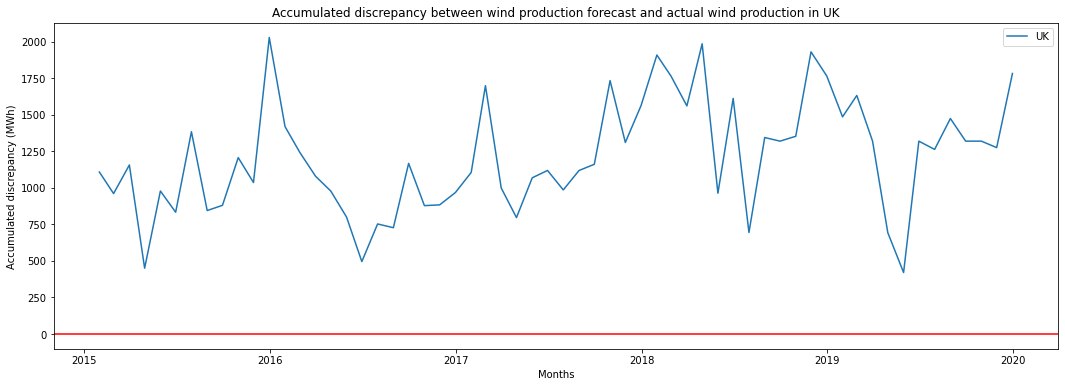

In [16]:
discrepancies_uk = abs(uk_wind_production['Quantity '] - uk_wind_forecast['Quantity'])
discrepancies_uk = discrepancies_uk.fillna(discrepancies_uk.mean())
discrepancies_uk_monthly = discrepancies_uk.resample('M').mean()

plt.figure(figsize=(18,6))

plt.plot(discrepancies_uk_monthly.index, discrepancies_uk_monthly, label='UK')
plt.axhline(0, color='red')

plt.title('Accumulated discrepancy between wind production forecast and actual wind production in UK')
plt.xlabel('Months')
plt.ylabel('Accumulated discrepancy (MWh)')
plt.legend()
pass

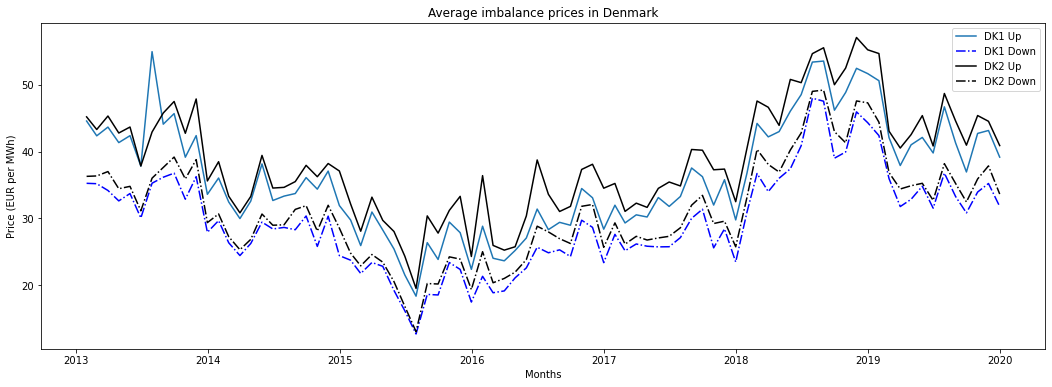

In [17]:
dk_imbalance_prices_monthly = dk_imbalance_prices.resample('M').mean() # taking mean monthly imbalance price

plt.figure(figsize=(18,6))
plt.title("Average imbalance prices in Denmark")
plt.xlabel('Months')
plt.ylabel('Price (EUR per MWh)')

plt.plot(dk_imbalance_prices_monthly.index, dk_imbalance_prices_monthly['DK1 Up'], label='DK1 Up')
plt.plot(dk_imbalance_prices_monthly.index, dk_imbalance_prices_monthly['DK1 Down'], label='DK1 Down', color='blue', linestyle='-.')

plt.plot(dk_imbalance_prices_monthly.index, dk_imbalance_prices_monthly['DK2 Up'], label='DK2 Up', color='black')
plt.plot(dk_imbalance_prices_monthly.index, dk_imbalance_prices_monthly['DK2 Down'], label='DK2 Down', color='black', linestyle='-.')


plt.legend()
plt.show()

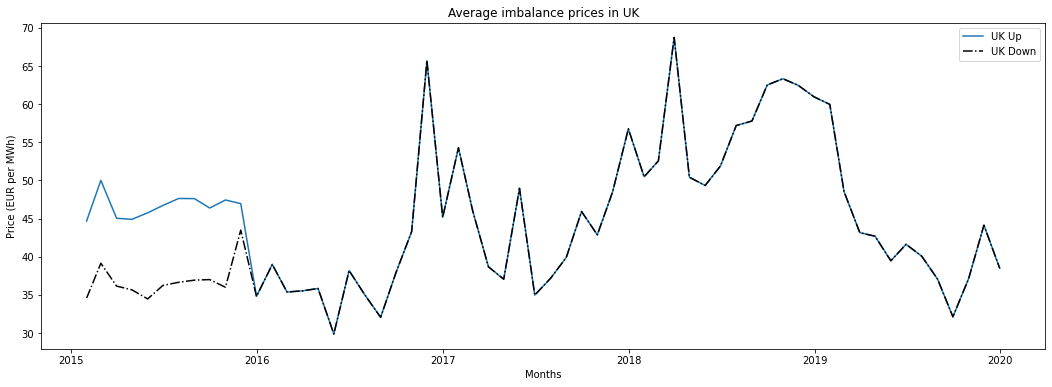

In [18]:
uk_imbalance_prices['SettlementDate'] = pd.to_datetime(uk_imbalance_prices['SettlementDate'])
uk_imbalance_prices.index = uk_imbalance_prices['SettlementDate']

uk_imbalance_prices_up = uk_imbalance_prices.loc[uk_imbalance_prices['PriceCategory'] == 'Insufficient balance']
uk_imbalance_prices_down = uk_imbalance_prices.loc[uk_imbalance_prices['PriceCategory'] == 'Excess balance']

uk_imbalance_prices_up_monthly = uk_imbalance_prices_up.resample('M').mean() # taking mean monthly imbalance price
uk_imbalance_prices_down_monthly = uk_imbalance_prices_down.resample('M').mean() # taking mean monthly imbalance price


plt.figure(figsize=(18,6))
plt.title("Average imbalance prices in UK")
plt.xlabel('Months')
plt.ylabel('Price (EUR per MWh)')

plt.plot(uk_imbalance_prices_up_monthly.index, uk_imbalance_prices_up_monthly['ImbalancePriceAmount'], label='UK Up')
plt.plot(uk_imbalance_prices_down_monthly.index, uk_imbalance_prices_down_monthly['ImbalancePriceAmount'], color='black', label='UK Down', linestyle='-.')
plt.legend()
plt.show()

## Correlations analysis
- Autocorrelations within all considered time series
- Correlations between all considered time series

## Quick thoughts right away
- Hourly production is seasonal, cyclic and highly forecastable (as per first implression)
- For it, and other time series highly correlated on the level of hour of the day, it makes sense to train predicting for that hour on the data from that hour
- Wind generation shows no significant autocorrelation whatsoever, but the curve falls slowly for small lags, meaning that usually the wind doesn't usually start or stop blowing immediately
- Day-ahead prices show not only relatively strong autocorrelation for 24-hour lag, but also a slight bump on 12-hour level
- Intraday prices seem to follow EXACTLY the same pattern of autocorrelation as day-ahead prices.
- Discrepancies are not autocorrelated, thus being proper noisy errors
- Demand is HIGHLY predictable, with autocorrelation coefficient up to 1 at certain lags
- Additional, long-term cycle in prices and deman is likely caused by the work days and weekends
- Wind forecasts seem to be the actual factor pushing down the day-ahead prices (logically, as they are the information at hand when the price is made)

- Where the presence of wind is lower in the overall production, it has a greater negative correlation with the price
- Gas prices don't seem to have a high correlation with the energy prices where the presence of wind energy is high

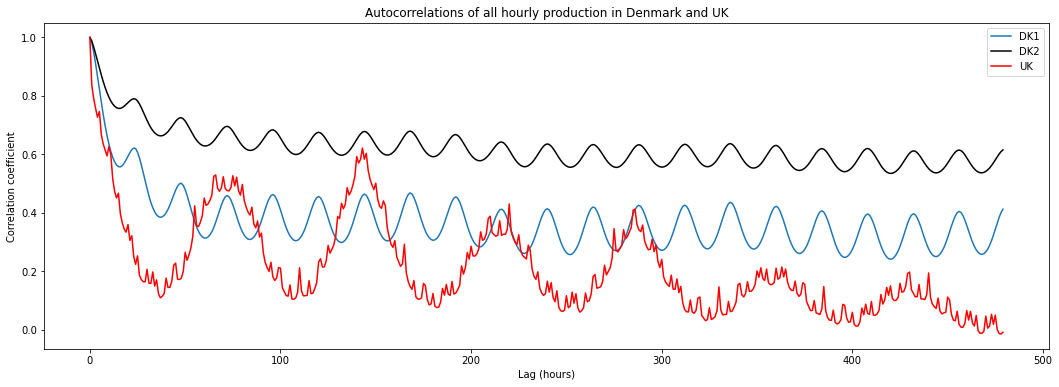

In [19]:
lags = 480

correlations_dk1 = []
correlations_dk2 = []
correlations_uk = []

for i in range(lags):
    correlations_dk1.append(dk_production_all['DK1'].autocorr(lag=i))
    correlations_dk2.append(dk_production_all['DK2'].autocorr(lag=i))
    correlations_uk.append(uk_production_all['Quantity'].autocorr(lag=2*i))
    
    
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1, label='DK1')
plt.plot(range(lags), correlations_dk2, label='DK2', color='black')
plt.plot(range(lags), correlations_uk, label='UK', color='red')

plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of all hourly production in Denmark and UK')

plt.legend()
plt.show()

In [20]:
uk_consumption_forecast_hourly = []
for i in range(uk_consumption_forecast.shape[0] - 1):
    uk_consumption_forecast_hourly.append(uk_consumption_forecast.iloc[i]['Quantity'] + uk_consumption_forecast.iloc[i+1]['Quantity'])
    
uk_consumption_forecast_hourly = pd.DataFrame({'Quantity': uk_consumption_forecast_hourly})

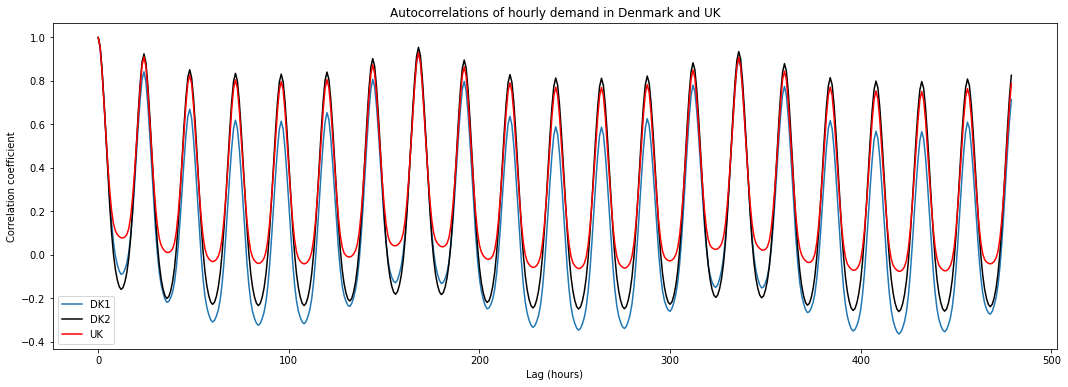

In [21]:
lags = 480

correlations_dk1 = []
correlations_dk2 = []
correlations_uk = []

for i in range(lags):
    correlations_dk1.append(dk_consumption_forecast['DK1'].autocorr(lag=i))
    correlations_dk2.append(dk_consumption_forecast['DK2'].autocorr(lag=i))
    correlations_uk.append(uk_consumption_forecast['Quantity'].autocorr(lag=2*i))
    
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1, label='DK1')
plt.plot(range(lags), correlations_dk2, label='DK2', color='black')
plt.plot(range(lags), correlations_uk, label='UK', color='red')

plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of hourly demand in Denmark and UK')

plt.legend()
plt.show()

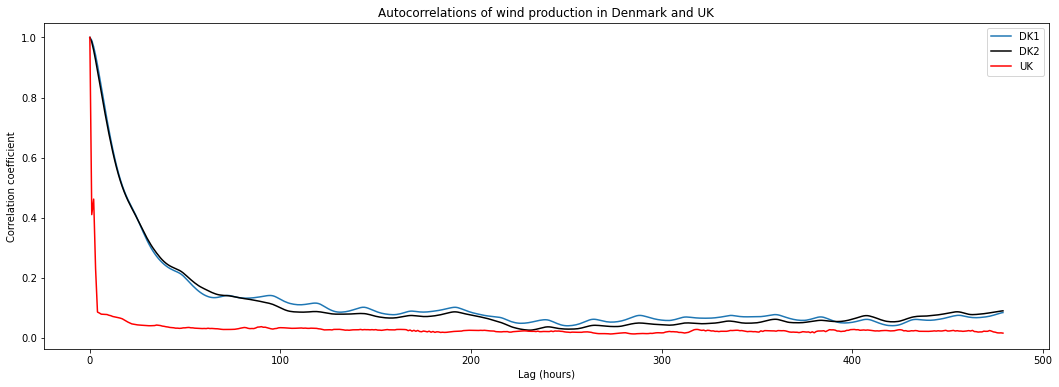

In [22]:
lags = 480

correlations_dk1 = []
correlations_dk2 = []
correlations_uk = []

for i in range(lags):
    correlations_dk1.append(dk_production_wind['DK1'].autocorr(lag=i))
    correlations_dk2.append(dk_production_wind['DK2'].autocorr(lag=i))
    correlations_uk.append(uk_wind_production['Quantity '].autocorr(lag=2*i))
    
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1, label='DK1')
plt.plot(range(lags), correlations_dk2, label='DK2', color='black')
plt.plot(range(lags), correlations_uk, label='UK', color='red')

plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of wind production in Denmark and UK')

plt.legend()
plt.show()

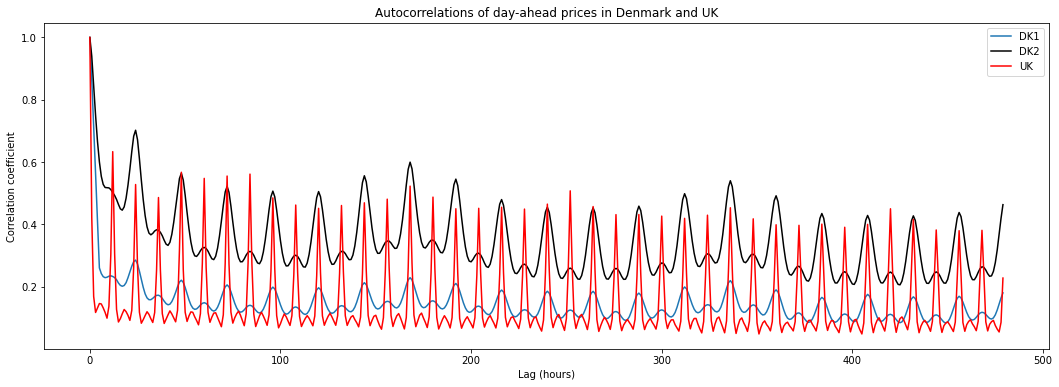

In [23]:
lags = 480

correlations_dk1 = []
correlations_dk2 = []
correlations_uk = []

for i in range(lags):
    correlations_dk1.append(dk_DA_prices['DK1'].autocorr(lag=i))
    correlations_dk2.append(dk_DA_prices['DK2'].autocorr(lag=i))
    correlations_uk.append(uk_DA_prices['Price'].autocorr(lag=2*i))
    
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1, label='DK1')
plt.plot(range(lags), correlations_dk2, label='DK2', color='black')
plt.plot(range(lags), correlations_uk, label='UK', color='red')

plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of day-ahead prices in Denmark and UK')

plt.legend()
plt.show()

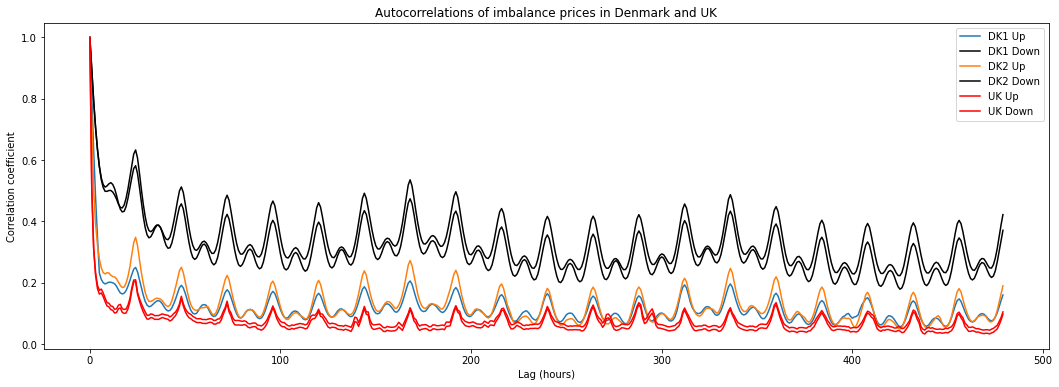

In [24]:
lags = 480

correlations_dk1_up = []
correlations_dk1_down = []
correlations_dk2_up = []
correlations_dk2_down = []
correlations_uk_up = []
correlations_uk_down = []

for i in range(lags):
    correlations_dk1_up.append(dk_imbalance_prices['DK1 Up'].autocorr(lag=i))
    correlations_dk1_down.append(dk_imbalance_prices['DK1 Down'].autocorr(lag=i))
    correlations_dk2_up.append(dk_imbalance_prices['DK2 Up'].autocorr(lag=i))
    correlations_dk2_down.append(dk_imbalance_prices['DK2 Down'].autocorr(lag=i))
    correlations_uk_up.append(uk_imbalance_prices_up['ImbalancePriceAmount'].autocorr(lag=2*i))
    correlations_uk_down.append(uk_imbalance_prices_down['ImbalancePriceAmount'].autocorr(lag=2*i))
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1_up, label='DK1 Up')
plt.plot(range(lags), correlations_dk1_down, label='DK1 Down', color='black')
plt.plot(range(lags), correlations_dk2_up, label='DK2 Up')
plt.plot(range(lags), correlations_dk2_down, label='DK2 Down', color='black')

plt.plot(range(lags), correlations_uk_up, label='UK Up', color='red')
plt.plot(range(lags), correlations_uk_down, label='UK Down', color='red')




plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of imbalance prices in Denmark and UK')

plt.legend()
plt.show()

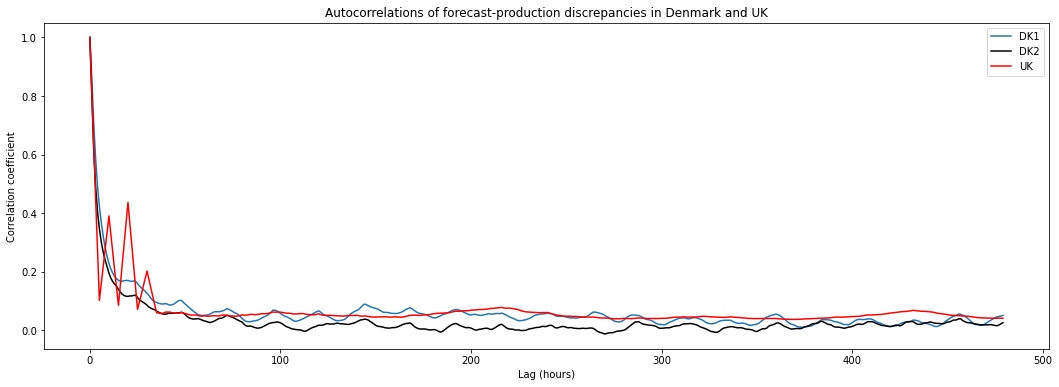

In [25]:
lags = 480

correlations_dk1 = []
correlations_dk2 = []
correlations_uk = []


for i in range(lags):
    correlations_dk1.append(discrepancies_dk['DK1'].autocorr(lag=i))
    correlations_dk2.append(discrepancies_dk['DK2'].autocorr(lag=i))
    correlations_uk.append(discrepancies_uk.autocorr(lag=2*i))
    
    
plt.figure(figsize=(18,6))
plt.plot(range(lags), correlations_dk1, label='DK1')
plt.plot(range(lags), correlations_dk2, label='DK2', color='black')
plt.plot(range(lags), correlations_uk, label='UK', color='red')

plt.xlabel('Lag (hours)')
plt.ylabel('Correlation coefficient')

plt.title('Autocorrelations of forecast-production discrepancies in Denmark and UK')

plt.legend()
plt.show()

In [26]:
# prepare data for a heatmap of correlations between all available data

def get_peak_and_offpeak(df):
    peak = df.loc[df['Hours'] == '17 - 18']
    off_peak = df.loc[df['Hours'] == '03 - 04']
    return peak, off_peak

# overall production and consumption
dk_prod_all_pk, dk_prod_all_offpk = get_peak_and_offpeak(dk_production_all)
dk_prod_f_pk, dk_prod_f_offpk = get_peak_and_offpeak(dk_production_forecast)
dk_cons_f_pk, dk_cons_f_offpk = get_peak_and_offpeak(dk_consumption_forecast)

# wind production and consumption
dk_prod_w_pk, dk_prod_w_offpk = get_peak_and_offpeak(dk_production_wind)
dk_prod_w_f_pk, dk_prod_w_f_offpk = get_peak_and_offpeak(dk_wind_forecast)

# prices - day-ahead and imbalance
dk_DA_p_pk, dk_DA_p_offpk = get_peak_and_offpeak(dk_DA_prices)
dk_imb_prices_pk, dk_imb_prices_offpk = get_peak_and_offpeak(dk_imbalance_prices)

peak_data_DK1 = [
    dk_prod_all_pk.reset_index(drop=True)["DK1"],
    dk_prod_f_pk.reset_index(drop=True)["DK1"],
    dk_cons_f_pk.reset_index(drop=True)["DK1"],
    dk_prod_w_pk.reset_index(drop=True)["DK1"],
    dk_prod_w_f_pk.reset_index(drop=True)["DK1"],
    dk_DA_p_pk.reset_index(drop=True)["DK1"],
    dk_imb_prices_pk.reset_index(drop=True)["DK1 Up"],
    dk_imb_prices_pk.reset_index(drop=True)["DK1 Down"],
    dk_gas.reset_index(drop=True)["PRICE"]
]

off_peak_data_DK1 = [
    dk_prod_all_offpk.reset_index(drop=True)["DK1"],
    dk_prod_f_offpk.reset_index(drop=True)["DK1"],
    dk_cons_f_offpk.reset_index(drop=True)["DK1"],
    dk_prod_w_offpk.reset_index(drop=True)["DK1"],
    dk_prod_w_f_offpk.reset_index(drop=True)["DK1"],
    dk_DA_p_offpk.reset_index(drop=True)["DK1"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK1 Up"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK1 Down"],
    dk_gas.reset_index(drop=True)["PRICE"]
]

peak_data_DK2 = [
    dk_prod_all_offpk.reset_index(drop=True)["DK1"],
    dk_prod_f_offpk.reset_index(drop=True)["DK1"],
    dk_cons_f_offpk.reset_index(drop=True)["DK1"],
    dk_prod_w_offpk.reset_index(drop=True)["DK1"],
    dk_prod_w_f_offpk.reset_index(drop=True)["DK1"],
    dk_DA_p_offpk.reset_index(drop=True)["DK1"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK1 Up"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK1 Down"],
    dk_gas.reset_index(drop=True)["PRICE"]
]

off_peak_data_DK2 = [
    dk_prod_all_offpk.reset_index(drop=True)["DK2"],
    dk_prod_f_offpk.reset_index(drop=True)["DK2"],
    dk_cons_f_offpk.reset_index(drop=True)["DK2"],
    dk_prod_w_offpk.reset_index(drop=True)["DK2"],
    dk_prod_w_f_offpk.reset_index(drop=True)["DK2"],
    dk_DA_p_offpk.reset_index(drop=True)["DK2"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK2 Up"],
    dk_imb_prices_offpk.reset_index(drop=True)["DK2 Down"],
    dk_gas.reset_index(drop=True)["PRICE"]
]

peak_data_DK1 = pd.concat(peak_data_DK1, axis=1)
peak_data_DK1.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']

off_peak_data_DK1 = pd.concat(off_peak_data_DK1, axis=1)
off_peak_data_DK1.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']

peak_data_DK2 = pd.concat(peak_data_DK2, axis=1)
peak_data_DK2.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']

off_peak_data_DK2 = pd.concat(off_peak_data_DK2, axis=1)
off_peak_data_DK2.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']

In [27]:
peak_data_DK1.index = pd.to_datetime(pd.date_range('01/01/2013', '31/12/2019', freq='D'))
off_peak_data_DK1.index = pd.to_datetime(pd.date_range('01/01/2013', '31/12/2019', freq='D'))
peak_data_DK2.index = pd.to_datetime(pd.date_range('01/01/2013', '31/12/2019', freq='D'))
off_peak_data_DK2.index = pd.to_datetime(pd.date_range('01/01/2013', '31/12/2019', freq='D'))

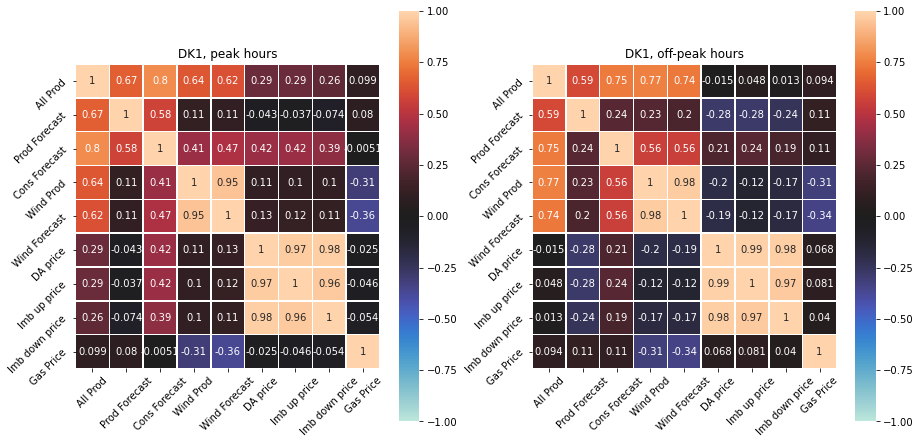

In [28]:
# build heatmaps for DK1

corr_dk1_pk = peak_data_DK1.resample('M').mean().corr(method ='pearson')
corr_dk1_offpk = off_peak_data_DK1.resample('M').mean().corr(method ='pearson')


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)

plt.title("DK1, peak hours")
ax = sns.heatmap(corr_dk1_pk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


plt.subplot(1, 2, 2)

plt.title("DK1, off-peak hours")
ax = sns.heatmap(corr_dk1_offpk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

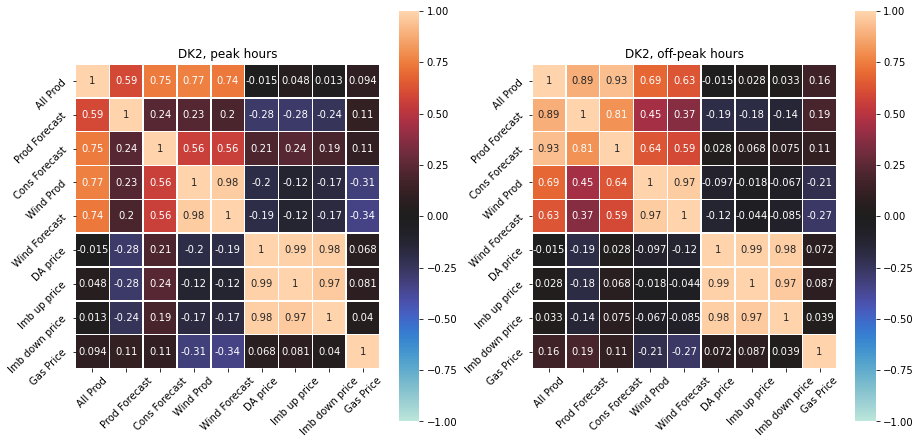

In [29]:
# build heatmaps for DK2

corr_dk2_pk = peak_data_DK2.resample('M').mean().corr(method ='pearson')
corr_dk2_offpk = off_peak_data_DK2.resample('M').mean().corr(method ='pearson')


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)

plt.title("DK2, peak hours")
ax = sns.heatmap(corr_dk2_pk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


plt.subplot(1, 2, 2)

plt.title("DK2, off-peak hours")
ax = sns.heatmap(corr_dk2_offpk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

pass

In [30]:
uk_consumption_forecast.columns = ['RecordType','SettlementDate', 'Settlement Period', 'Zone', 'TimePublished', 'Quantity']
uk_imbalance_prices_up = uk_imbalance_prices_up.rename(columns={'SettlementPeriod': 'Settlement Period'})
uk_imbalance_prices_down = uk_imbalance_prices_down.rename(columns={'SettlementPeriod': 'Settlement Period'})
uk_DA_prices['Price'] = uk_DA_prices['Price'].fillna(uk_DA_prices['Price'].mean())

In [31]:
# resample everything after settlement period filtering
#uk_production_all.resample('D').sum()

uk_production_forecast.index = pd.to_datetime(uk_production_forecast['Settlement Date']) # leave this
uk_consumption_forecast = uk_consumption_forecast.rename(columns={'SettlementPeriod': 'Settlement Period'})

In [32]:
# prepare data for a heatmap of correlations between all available data

def get_peak_and_offpeak(df):
    peak = df.loc[df['Settlement Period'].isin([33, 34, 35, 36])]
    off_peak = df.loc[df['Settlement Period'].isin([5, 6, 7, 8])]
    return peak, off_peak

def get_peak_and_offpeak_by_hours(df):
    peak = df.loc[df['Hour_2'] == '17\xa0-\xa018']
    off_peak = df.loc[df['Hour_2'] == '03\xa0-\xa004']
    return peak, off_peak

# overall production and consumption
uk_prod_all_pk, uk_prod_all_offpk = get_peak_and_offpeak(uk_production_all)
uk_prod_f_pk, uk_prod_f_offpk = get_peak_and_offpeak(uk_production_forecast)
uk_cons_f_pk, uk_cons_f_offpk = get_peak_and_offpeak(uk_consumption_forecast)

# wind production and consumption
uk_prod_w_pk, uk_prod_w_offpk = get_peak_and_offpeak(uk_wind_production)
uk_prod_w_f_pk, uk_prod_w_f_offpk = get_peak_and_offpeak(uk_wind_forecast)

# prices - day-ahead and imbalance
uk_DA_p_pk, uk_DA_p_offpk = get_peak_and_offpeak_by_hours(uk_DA_prices)
uk_imbalance_prices_up_pk, uk_imbalance_prices_up_offpk = get_peak_and_offpeak(uk_imbalance_prices_up)
uk_imbalance_prices_down_pk, uk_imbalance_prices_down_offpk = get_peak_and_offpeak(uk_imbalance_prices_down)


#####peak
peak_data_uk = uk_prod_all_pk.resample('M').mean().join(uk_prod_f_pk.resample('M').mean(), lsuffix='_allprod', rsuffix='_allprodforecast').join(uk_cons_f_pk.resample('M').mean(), rsuffix='_consforecast').join(uk_prod_w_pk["Quantity "].resample('M').mean(), lsuffix='_consforecast', rsuffix='_windprod').join(uk_prod_w_f_pk.resample('M').mean(), rsuffix='_windforecast').join(uk_DA_p_pk["Price"].resample('M').mean(), rsuffix='_daprice').join(uk_imbalance_prices_up_pk["ImbalancePriceAmount"].resample('M').mean(), rsuffix='_imbpriceup').join(uk_imbalance_prices_down_pk["ImbalancePriceAmount"].resample('M').mean(), rsuffix='_imbpricedown').join(uk_gas["PRICE"].resample('M').mean(), rsuffix='_gas')
peak_data_uk['Quantity_allprodforecast'] = peak_data_uk['Quantity_allprodforecast'].fillna(peak_data_uk['Quantity_allprodforecast'].mean())
peak_data_uk['Quantity '] = peak_data_uk['Quantity '].fillna(peak_data_uk['Quantity '].mean())

peak_data_uk = peak_data_uk[['Quantity_allprod', 'Quantity_allprodforecast', 'Quantity', 'Quantity ', 'Quantity_windforecast', 'Price', 'ImbalancePriceAmount', 'ImbalancePriceAmount_imbpricedown', 'PRICE']]
peak_data_uk.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']



#####offpeak
off_peak_data_uk = uk_prod_all_offpk.resample('M').mean().join(uk_prod_f_offpk.resample('M').mean(), lsuffix='_allprod', rsuffix='_allprodforecast').join(uk_cons_f_offpk.resample('M').mean(), rsuffix='_consforecast').join(uk_prod_w_offpk["Quantity "].resample('M').mean(), lsuffix='_consforecast', rsuffix='_windprod').join(uk_prod_w_f_offpk.resample('M').mean(), rsuffix='_windforecast').join(uk_DA_p_offpk["Price"].resample('M').mean(), rsuffix='_daprice').join(uk_imbalance_prices_up_offpk["ImbalancePriceAmount"].resample('M').mean(), rsuffix='_imbpriceup').join(uk_imbalance_prices_down_offpk["ImbalancePriceAmount"].resample('M').mean(), rsuffix='_imbpricedown').join(uk_gas["PRICE"].resample('M').mean(), rsuffix='_gas')
off_peak_data_uk['Quantity_allprodforecast'] = off_peak_data_uk['Quantity_allprodforecast'].fillna(off_peak_data_uk['Quantity_allprodforecast'].mean())
off_peak_data_uk['Quantity '] = off_peak_data_uk['Quantity '].fillna(off_peak_data_uk['Quantity '].mean())

off_peak_data_uk = off_peak_data_uk[['Quantity_allprod', 'Quantity_allprodforecast', 'Quantity', 'Quantity ', 'Quantity_windforecast', 'Price', 'ImbalancePriceAmount', 'ImbalancePriceAmount_imbpricedown', 'PRICE']]
off_peak_data_uk.columns = ['All Prod', 'Prod Forecast', 'Cons Forecast', 'Wind Prod', 'Wind Forecast', 'DA price', 'Imb up price', 'Imb down price', 'Gas Price']

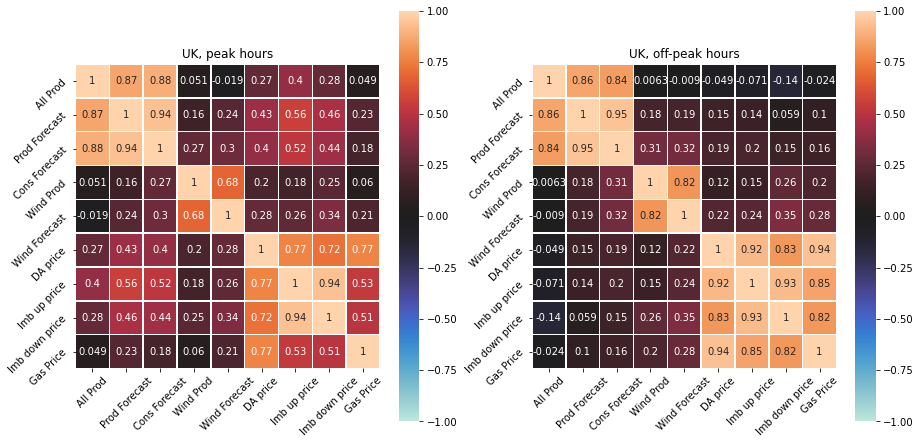

In [34]:
# build heatmaps for UK

corr_uk_pk = peak_data_uk.corr(method ='pearson')
corr_uk_offpk = off_peak_data_uk.corr(method ='pearson')


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)

plt.title("UK, peak hours")
ax = sns.heatmap(corr_uk_pk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


plt.subplot(1, 2, 2)

plt.title("UK, off-peak hours")
ax = sns.heatmap(corr_uk_offpk, vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True)
ax.margins(x = 0.1, y= 0.1)
ax.use_sticky_edges = False
ax.autoscale_view(scaley = False, scalex = False)
ax.figure.subplots_adjust(bottom = 0.5)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

pass